<a href="https://colab.research.google.com/github/aryu99/IBM-Hackathon/blob/master/wind_power_forecasting_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import torch

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset 3.csv to dataset 3.csv


In [3]:
dataset = pd.read_csv("dataset 3.csv", encoding= 'unicode_escape')
TRAIN_SPLIT = 52561

In [4]:
print (dataset)

               Date/Time  ...  Wind Speed (m/s)
0           1 1 2018 0:0  ...            16.418
1          1 1 2018 0:10  ...            16.653
2          1 1 2018 0:20  ...            16.919
3          1 1 2018 0:30  ...            16.989
4          1 1 2018 0:40  ...            17.096
...                  ...  ...               ...
105115  31 12 2019 23:15  ...            17.670
105116  31 12 2019 23:25  ...            16.965
105117  31 12 2019 23:35  ...            16.214
105118  31 12 2019 23:45  ...            16.116
105119  31 12 2019 23:55  ...            16.345

[105120 rows x 4 columns]


In [5]:
dataset.info

<bound method DataFrame.info of                Date/Time  ...  Wind Speed (m/s)
0           1 1 2018 0:0  ...            16.418
1          1 1 2018 0:10  ...            16.653
2          1 1 2018 0:20  ...            16.919
3          1 1 2018 0:30  ...            16.989
4          1 1 2018 0:40  ...            17.096
...                  ...  ...               ...
105115  31 12 2019 23:15  ...            17.670
105116  31 12 2019 23:25  ...            16.965
105117  31 12 2019 23:35  ...            16.214
105118  31 12 2019 23:45  ...            16.116
105119  31 12 2019 23:55  ...            16.345

[105120 rows x 4 columns]>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ae0c13710>,
      dtype=object)

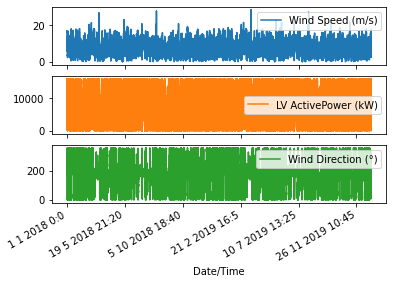

In [6]:
df = dataset
features_considered = ['Wind Speed (m/s)', 'LV ActivePower (kW)', 'Wind Direction (°)']
features = df[features_considered]
features.index = df['Date/Time']
features.head()
features.plot(subplots=True)

In [7]:
dataset_mean = df.mean(axis = 0)
dataset_std = df.std(axis = 0)
print(dataset_mean[1])

7383.827844368341


In [8]:
df3 = df
df2 = df

In [9]:
features_considered = ['Wind Speed (m/s)', 'Wind Direction (°)']
features = df3[features_considered]
features.index = df3['Date/Time']
features.tail()

dataset = features.values

data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [10]:
features_considered_labels = ['Wind Speed (m/s)', 'LV ActivePower (kW)', 'Wind Direction (°)']
features_mod = df2[features_considered_labels]
features_mod.index = df2['Date/Time']
features_mod.tail()

dataset_mod = features_mod.values

data_mean_mod = dataset_mod[:TRAIN_SPLIT].mean(axis=0)
data_std_mod = dataset_mod[:TRAIN_SPLIT].std(axis=0)
dataset_mod = (dataset_mod-data_mean_mod)/data_std_mod

In [11]:
# For extracting one data point per hour(Taking steps of 6, as data recorded every 10 min)
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])
    labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [12]:
past_history = 720
future_target = 432
STEP = 6
BUFFER_SIZE = 10000
BATCH_SIZE = 256

x_train_multi, y_train_multi = multivariate_data(dataset, dataset_mod[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset_mod[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP) 

In [13]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target power to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 2)

 Target power to predict : (432,)


In [14]:
# Conversion into tensors and splitting of data into mini-batches
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [15]:
def create_time_steps(length):
  return list(range(-length, 0))

In [16]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

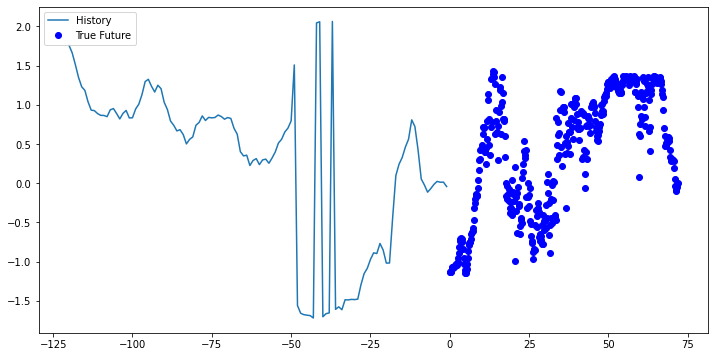

In [17]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [18]:
# Defining the model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(432))

multi_step_model.compile(optimizer='adam', loss='mae')

In [19]:
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 432)               7344      
Total params: 14,960
Trainable params: 14,960
Non-trainable params: 0
_________________________________________________________________


In [20]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 432)


In [21]:
EVALUATION_INTERVAL = 200
EPOCHS = 250

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/250
200/200 [==============================] - 36s 182ms/step - loss: 0.8488 - val_loss: 0.9143
Epoch 2/250
200/200 [==============================] - 36s 180ms/step - loss: 0.8009 - val_loss: 0.8723
Epoch 3/250
200/200 [==============================] - 36s 179ms/step - loss: 0.7711 - val_loss: 0.8710
Epoch 4/250
200/200 [==============================] - 36s 182ms/step - loss: 0.7275 - val_loss: 0.8233
Epoch 5/250
200/200 [==============================] - 36s 181ms/step - loss: 0.6893 - val_loss: 0.8046
Epoch 6/250
200/200 [==============================] - 36s 181ms/step - loss: 0.6610 - val_loss: 0.7613
Epoch 7/250
200/200 [==============================] - 37s 183ms/step - loss: 0.6313 - val_loss: 0.7512
Epoch 8/250
200/200 [==============================] - 36s 182ms/step - loss: 0.6053 - val_loss: 0.6991
Epoch 9/250
200/200 [==============================] - 36s 181ms/step - loss: 0.5821 - val_loss: 0.6719
Epoch 10/250
200/200 [==============================] - 36s 182m

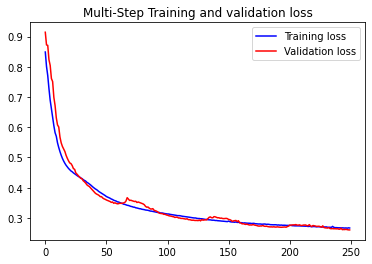

In [22]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [23]:
def multivariate_data_predict(dataset, past_window):
                      
  data = []
  end_index = len(dataset)
  start_index = len(dataset) - past_window

  for i in range(start_index, end_index):
    data.append(dataset[i])
    

  return np.array(data)

In [41]:
uploaded_predict = files.upload()

Saving dataset_predict.csv to dataset_predict.csv


In [42]:
# Importing the previous 5 days weather data
predict_dataset = pd.read_csv("dataset_predict.csv", encoding= 'unicode_escape')
print(predict_dataset)

          Date/Time  Wind Direction (°)  Wind Speed (m/s)
0      1 1 2018 0:0             336.296            16.418
1     1 1 2018 0:10             337.510            16.653
2     1 1 2018 0:20             337.927            16.919
3     1 1 2018 0:30             338.174            16.989
4     1 1 2018 0:40             338.433            17.096
..              ...                 ...               ...
115  1 1 2018 19:10             324.738            10.977
116  1 1 2018 19:20             328.253            11.590
117  1 1 2018 19:30             330.918            11.325
118  1 1 2018 19:40             330.715            11.712
119  1 1 2018 19:50             330.654            11.969

[120 rows x 3 columns]


In [43]:
# Normalising the data w.r.t the training dataset
df4 = predict_dataset
predict_features_considered = ['Wind Speed (m/s)', 'Wind Direction (°)']
predict_features = df4[predict_features_considered]
predict_features.index = df4['Date/Time']
predict_features.tail()

predict_dataset = predict_features.values

predict_dataset_mod = (predict_dataset-data_mean)/data_std

In [44]:
BATCH_SIZE_predict = 120
past_history_predict = 120 

x_predict_multi = multivariate_data_predict(predict_dataset_mod, past_history_predict)

In [45]:
x_predict_multi = tf.data.Dataset.from_tensor_slices((x_predict_multi))
x_predict_multi = x_predict_multi.batch(BATCH_SIZE_predict).repeat()
x_predict_multi = x_predict_multi.batch(BATCH_SIZE_predict).repeat()

In [46]:
# Output predictions for the next 3 days(6 predictions per hour * 72 hours = 432 data points)
predictions_raw = multi_step_model.predict(x_predict_multi.take(1))
predictions_array = (predictions_raw*dataset_std[1]) + dataset_mean[1]
predictions = predictions_array[0]
for i in range(120):
  if predictions[i] < 0:
    predictions[i] = 0
print(predictions)


[14428.57   14477.85   14464.2295 14529.75   14528.515  14616.895
 14716.596  14688.825  14750.859  14762.001  14805.369  14814.52
 14948.732  15035.072  15050.607  15054.34   15014.978  14921.8955
 14902.684  14867.609  14977.669  14906.997  14939.684  14831.521
 14766.288  14746.826  14637.012  14498.801  14458.783  14326.746
 14253.398  14102.029  14021.4    13872.289  13806.8125 13735.564
 13562.2705 13384.978  13177.377  13023.783  12775.484  12414.355
 12274.278  11966.719  11722.297  11483.154  11205.201  10950.712
 10818.619  10426.65   10268.979  10116.662   9903.515   9514.11
  9317.717   9078.183   8856.921   8562.182   8325.972   8125.006
  7860.2026  7613.3105  7247.355   7098.196   6901.9624  6701.9287
  6439.9434  6223.431   6000.033   5859.259   5672.9717  5556.315
  5400.855   5227.8584  5020.2793  4800.1055  4685.5435  4560.048
  4445.133   4365.339   4325.2573  4358.046   4264.607   4250.4146
  4251.0107  4203.449   4125.1816  4151.255   4151.293   4193.54
  4225.211

In [47]:
# Function for plotting the predicted values
def output_plot(output):
  plt.plot(output)
  plt.xlabel("Predictions made every 10 min for the next 72 hours")
  plt.ylabel("Active Power Output (kW)")
  plt.show()

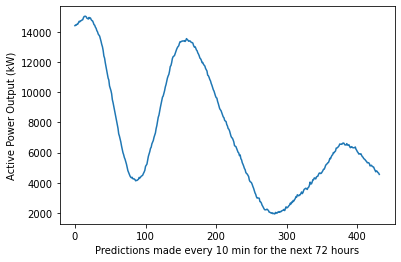

In [48]:
output_plot(predictions)

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [37]:
#using model.save_weights() to save the weights of the model in HDF5 format
multi_step_model.save_weights("/content/gdrive/My Drive/weights_final.h5")

In [38]:
multi_step_model.save("/content/gdrive/My Drive/model_final.h5")